In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import scipy.stats as stats
import statsmodels.api as sm
import itertools

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.formula.api import ols

In [38]:
df = pd.read_csv("Задания/Datasets/euroweight.dat.txt", delim_whitespace=True, header=None, on_bad_lines='skip')
df.columns = ['CaseNumber', 'Weight', 'NumberOfPackage']
print(df.shape)
df.head(20)

(2000, 3)


/var/folders/19/c1rn4t0n4qn2h0cjhj9f9_3r0000gn/T/ipykernel_62435/3392309208.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("Задания/Datasets/euroweight.dat.txt", delim_whitespace=True, header=None, on_bad_lines='skip')


,CaseNumber,Weight,NumberOfPackage
0,1,7.512,1
1,2,7.502,1
2,3,7.461,1
3,4,7.562,1
4,5,7.528,1
5,6,7.459,1
6,7,7.518,1
7,8,7.537,1
8,9,7.517,1
9,10,7.605,1


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CaseNumber       2000 non-null   int64  
 1   Weight           2000 non-null   float64
 2   NumberOfPackage  2000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 47.0 KB


In [40]:
data = df.copy()
df.isnull().sum()

CaseNumber         0
Weight             0
NumberOfPackage    0
dtype: int64

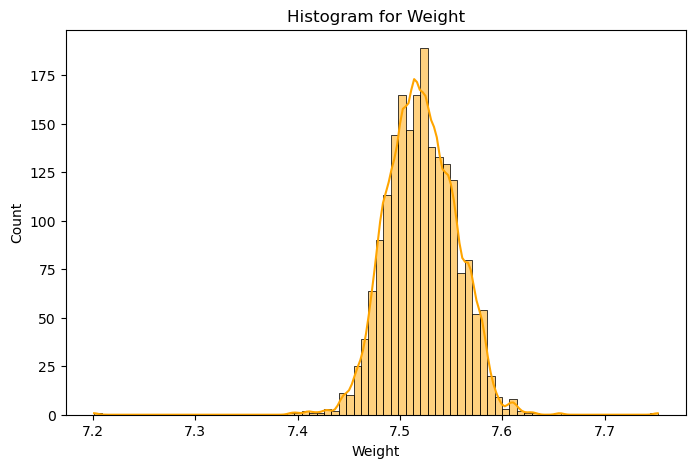

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Weight'], kde=True, color='orange', kde_kws={'bw_adjust': 0.5})  
# kde=True adds a density line
# bw_adjust adjusts the level of smoothing for the KDE
plt.title('Histogram for Weight')
plt.show()

In [42]:
# Shapiro-Wilk
stat, p = stats.shapiro(df['Weight'])
print('Shapiro-Wilk:')
print('Statistic:', stat, 'p-value:', p)
if p < 0.05:
    print("There is no normal distribution")
if p > 0.05:
    print("There is a normal distribution")

Shapiro-Wilk:
Statistic: 0.9754729009998673 p-value: 5.0232770717677785e-18
There is no normal distribution


    Гипотеза о нормальном  распределении выполняется для общей кучи

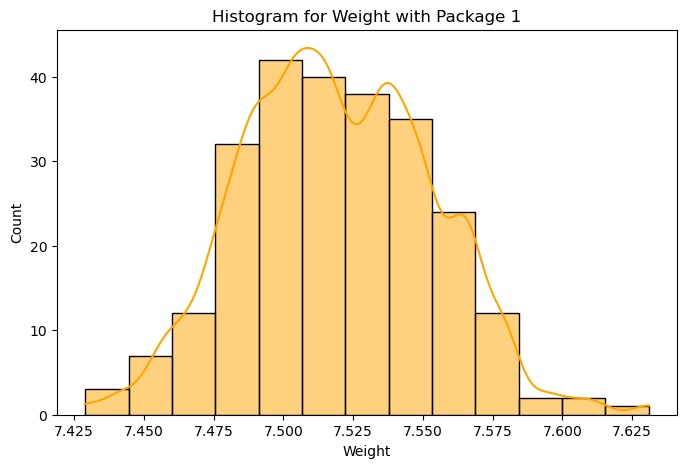

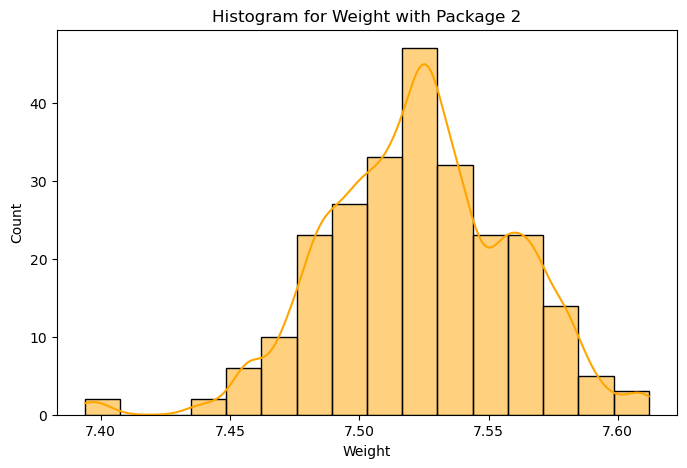

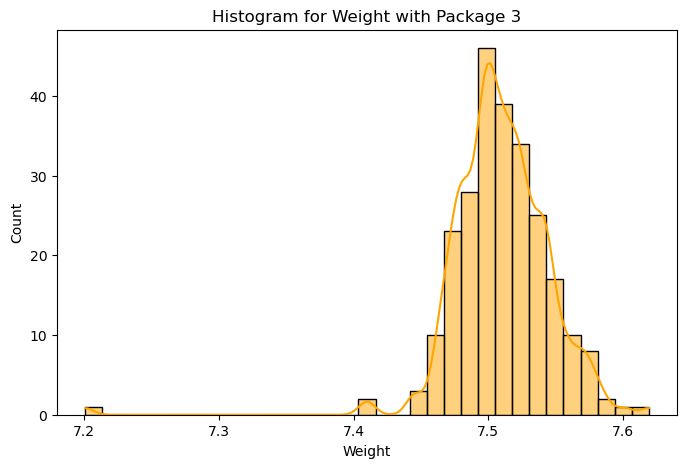

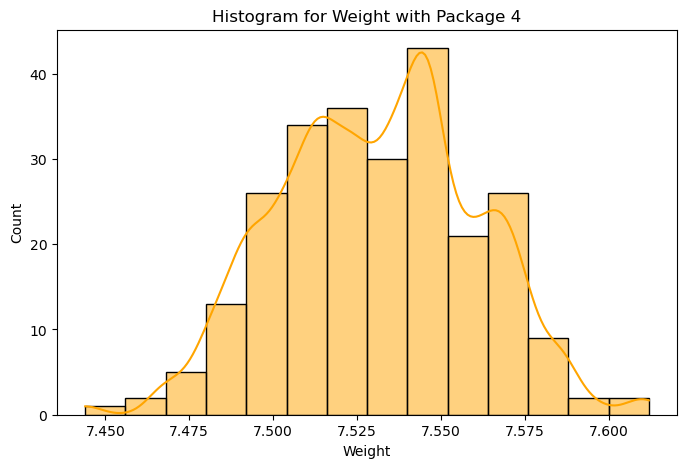

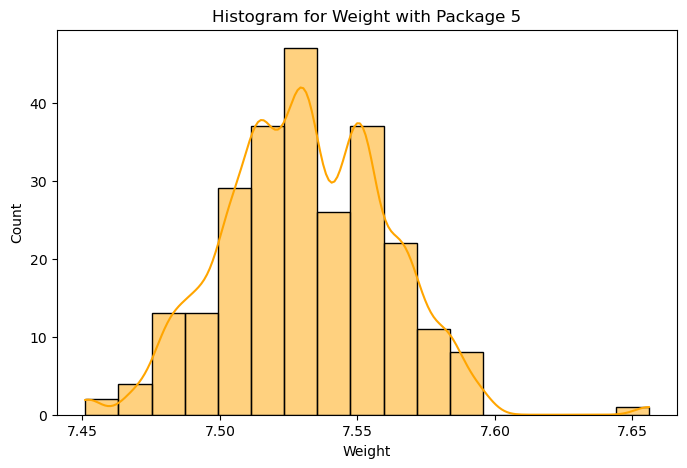

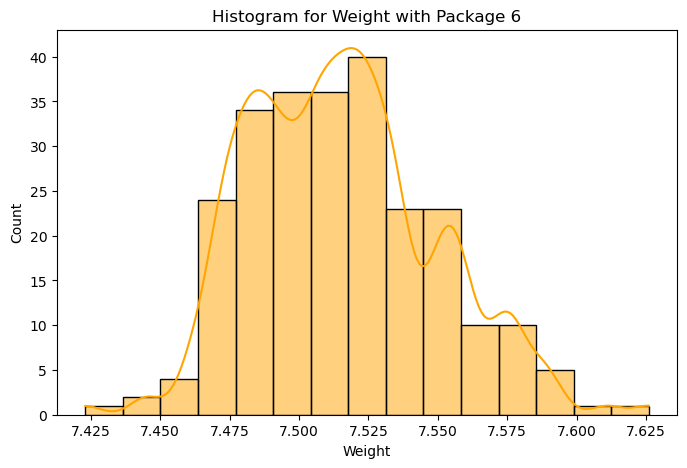

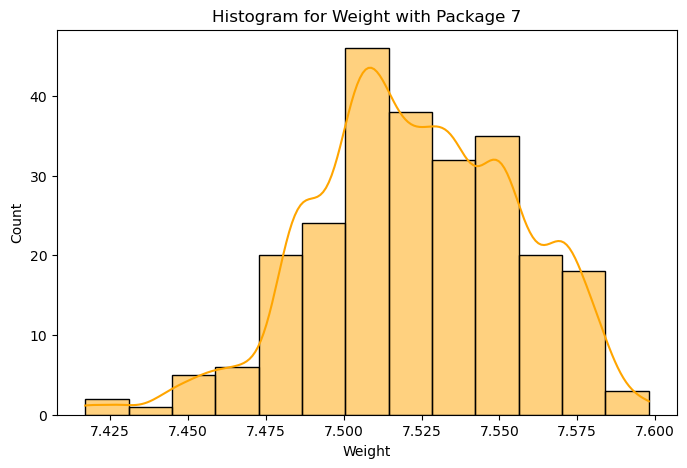

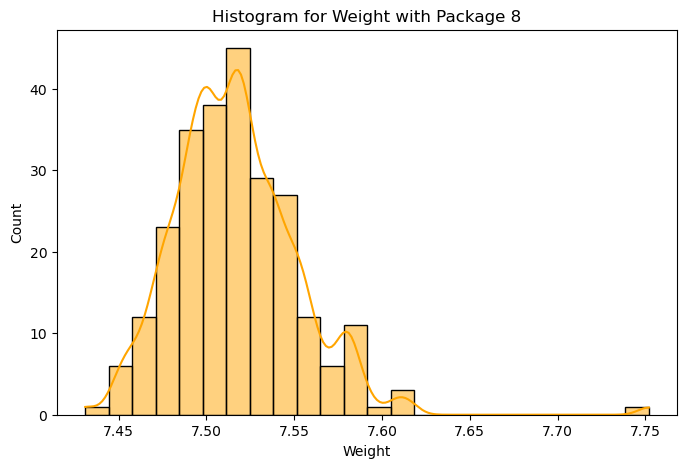

In [43]:
for i in range(1, 9):
    subdata = df[df['NumberOfPackage'] == i]
    plt.figure(figsize=(8, 5))
    sns.histplot(subdata['Weight'], kde=True, color='orange', kde_kws={'bw_adjust': 0.5})  
    # kde=True adds a density line
    # bw_adjust adjusts the level of smoothing for the KDE
    plt.title(f'Histogram for Weight with Package {i}')
    plt.show()

In [44]:
for i in range(1, 9):
    subdata = df[df['NumberOfPackage'] == i]
    
    # Shapiro-Wilk
    stat, p = stats.shapiro(subdata['Weight'])
    print(f"Shapiro-Wilk for Pack {i}:")
    print('Statistic:', stat, 'p-value:', p)
    if p < 0.05:
        print("There is no normal distribution")
    if p > 0.05:
        print("There is a normal distribution")

Shapiro-Wilk for Pack 1:
Statistic: 0.9955065633661131 p-value: 0.6830016984325032
There is a normal distribution
Shapiro-Wilk for Pack 2:
Statistic: 0.9909000904488605 p-value: 0.12187697982854381
There is a normal distribution
Shapiro-Wilk for Pack 3:
Statistic: 0.8634321390915005 p-value: 4.0894442659130386e-14
There is no normal distribution
Shapiro-Wilk for Pack 4:
Statistic: 0.9955047033510325 p-value: 0.6826586479147758
There is a normal distribution
Shapiro-Wilk for Pack 5:
Statistic: 0.9910339934809614 p-value: 0.12899280195551283
There is a normal distribution
Shapiro-Wilk for Pack 6:
Statistic: 0.9840594568487767 p-value: 0.006756498703670199
There is no normal distribution
Shapiro-Wilk for Pack 7:
Statistic: 0.9907008441292615 p-value: 0.1119834333901041
There is a normal distribution
Shapiro-Wilk for Pack 8:
Statistic: 0.9367201394772204 p-value: 6.82769744861544e-09
There is no normal distribution


**Рассмотрим случай когда отбросим мешки без нормального распределения, для остальных будем использовать тест ANOVA**

In [45]:
selected_packages = [1, 2, 4, 5, 7]
    
# Conducting one-way ANOVA only for selected packages
# Filtering the DataFrame for selected packages
filtered_df = df[df['NumberOfPackage'].isin(selected_packages)]

# Creating the formula for ANOVA
model = ols('Weight ~ C(NumberOfPackage)', data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nResults of Analysis of Variance (ANOVA):")
print(anova_table)

# Interpretation of results
alpha = 0.05
# Using iloc to access the p-value
if anova_table['PR(>F)'].iloc[0] < alpha:
    print("There are statistically significant differences between the mean values of the packages.")
else:
    print("There are no statistically significant differences between the mean values of the packages.")


Results of Analysis of Variance (ANOVA):
                      sum_sq      df         F    PR(>F)
C(NumberOfPackage)  0.027947     4.0  6.626481  0.000028
Residual            1.312680  1245.0       NaN       NaN
There are statistically significant differences between the mean values of the packages.


**Для сравнения каждого с каждым будем использовать метод попарных сравнений t-test Стьюдента**

In [46]:
# Get unique package numbers
unique_packages = filtered_df['NumberOfPackage'].unique()

# Dictionary to store t-test results
results = {}

# Perform pairwise t-test for each pair of packages
for package1, package2 in itertools.combinations(unique_packages, 2):
    weights1 = filtered_df[filtered_df['NumberOfPackage'] == package1]['Weight']
    weights2 = filtered_df[filtered_df['NumberOfPackage'] == package2]['Weight']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(weights1, weights2, equal_var=False)  # equal_var=False for Welch's t-test
    
    # Store results
    results[(package1, package2)] = p_value

# Output results
print("\nResults of pairwise t-test:")
alpha = 0.05
for (pkg1, pkg2), p_val in results.items():
    print(f"Packages {pkg1} and {pkg2}: p-value = {p_val:.4f}")
    if p_val < alpha:
        print("    There are statistically significant differences between the means.")
    else:
        print("    No statistically significant differences between the means.")


Results of pairwise t-test:
Packages 1 and 2: p-value = 0.2615
    No statistically significant differences between the means.
Packages 1 and 4: p-value = 0.0001
    There are statistically significant differences between the means.
Packages 1 and 5: p-value = 0.0001
    There are statistically significant differences between the means.
Packages 1 and 7: p-value = 0.2653
    No statistically significant differences between the means.
Packages 2 and 4: p-value = 0.0067
    There are statistically significant differences between the means.
Packages 2 and 5: p-value = 0.0051
    There are statistically significant differences between the means.
Packages 2 and 7: p-value = 0.9605
    No statistically significant differences between the means.
Packages 4 and 5: p-value = 0.9120
    No statistically significant differences between the means.
Packages 4 and 7: p-value = 0.0040
    There are statistically significant differences between the means.
Packages 5 and 7: p-value = 0.0029
    There 

**Рассмотрим общий случай. Для него будем использовать тест Краскела-Уолиса**

In [47]:
# Perform the Kruskal-Wallis test
h_statistic, p_value = stats.kruskal(
    df[df['NumberOfPackage'] == 1]['Weight'],
    df[df['NumberOfPackage'] == 2]['Weight'],
    df[df['NumberOfPackage'] == 3]['Weight'],
    df[df['NumberOfPackage'] == 4]['Weight'],
    df[df['NumberOfPackage'] == 5]['Weight'],
    df[df['NumberOfPackage'] == 6]['Weight'],
    df[df['NumberOfPackage'] == 7]['Weight'],
    df[df['NumberOfPackage'] == 8]['Weight']
)

# Output results
print(f"H-statistic: {h_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: the distributions differ.")
else:
    print("Failed to reject the null hypothesis: the distributions do not differ.")

H-statistic: 97.4998
P-value: 0.0000
Reject the null hypothesis: the distributions differ.


**Для сравнения каждого с каждым будем использовать метод попарных сравнений Краскела-Уолиса**

In [48]:
# Get unique package numbers
unique_packages = df['NumberOfPackage'].unique()

# Dictionary to store t-test results
results = {}

# Perform pairwise t-tests for each package pair
for package1, package2 in itertools.combinations(unique_packages, 2):
    weights1 = df[df['NumberOfPackage'] == package1]['Weight']
    weights2 = df[df['NumberOfPackage'] == package2]['Weight']
    
    # Perform the t-test
    t_stat, p_value = stats.kruskal(weights1, weights2)
    
    # Store the results
    results[(package1, package2)] = p_value

# Output results
print("\nResults of pairwise t-tests:")
alpha = 0.05
for (pkg1, pkg2), p_val in results.items():
    print(f"Packages {pkg1} and {pkg2}: p-value = {p_val:.4f}")
    if p_val < alpha:
        print("    There are statistically significant differences between the means.")
    else:
        print("    No statistically significant differences between the means.")


Results of pairwise t-tests:
Packages 1 and 2: p-value = 0.1949
    No statistically significant differences between the means.
Packages 1 and 3: p-value = 0.0025
    There are statistically significant differences between the means.
Packages 1 and 4: p-value = 0.0001
    There are statistically significant differences between the means.
Packages 1 and 5: p-value = 0.0001
    There are statistically significant differences between the means.
Packages 1 and 6: p-value = 0.0959
    No statistically significant differences between the means.
Packages 1 and 7: p-value = 0.1768
    No statistically significant differences between the means.
Packages 1 and 8: p-value = 0.1931
    No statistically significant differences between the means.
Packages 2 and 3: p-value = 0.0000
    There are statistically significant differences between the means.
Packages 2 and 4: p-value = 0.0093
    There are statistically significant differences between the means.
Packages 2 and 5: p-value = 0.0082
    There